<a href="https://colab.research.google.com/github/CarmenTheodoraCraciun/HairTextureClassification/blob/main/MLP_HairTexture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Enviroment

In [ ]:
!pip install opencv-python
!pip install tensorflow
!pip install efficientnet

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 50.7/50.7 kB 3.1 MB/s eta 0:00:00


In [ ]:
!rm -rf ./HairTextureClassification
!git clone https://github.com/CarmenTheodoraCraciun/HairTextureClassification.git

Cloning into 'HairTextureClassification'...
remote: Enumerating objects: 30866, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 30866 (delta 16), reused 5 (delta 5), pack-reused 30835 (from 4)
Receiving objects: 100% (30866/30866), 824.43 MiB | 24.90 MiB/s, done.
Resolving deltas: 100% (62/62), done.
Updating files: 100% (16607/16607), done.


In [ ]:
import os
import cv2
import shutil
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam, SGD, AdamW, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import LeakyReLU, BatchNormalization, AveragePooling2D
from keras.optimizers.schedules import ExponentialDecay, PolynomialDecay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

##Optimizing the training environment and leaning up the TensorFlow session

* Enabling mixed precision for optimal performance on the GPU
* To avoid memory issues

In [ ]:
mixed_precision.set_global_policy('mixed_float16')
tf.keras.backend.clear_session()
collected = gc.collect()
print(f"Garbage collector freed {collected} unreachable objects.")

Garbage collector freed 0 unreachable objects.


#Loading data

In [ ]:
def load_images_and_labels(input_dir, size=(96, 96)):
    images = []
    labels = []
    invalid_images = []

    for category in os.listdir(input_dir):
        category_dir = os.path.join(input_dir, category)
        if os.path.isdir(category_dir):
            for img_name in os.listdir(category_dir):
                img_path = os.path.join(category_dir, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)
                    images.append(img)
                    labels.append(category)

                    if img.shape[:2] != (96, 96):
                        invalid_images.append((img_name, img.shape[:2]))

    if invalid_images:
        print("Warning: Some images are not 96x96!")
        for img_name, shape in invalid_images:
            print(f" {img_name} has size {shape}")

    return np.array(images), np.array(labels)

In [ ]:
images, labels = load_images_and_labels('./HairTextureClassification/processData')

##Normalized images

In [ ]:
images = images.astype('float32') / 255.0
assert images.shape[1:] == (96, 96, 3), f"Error: Some images are not 96x96! Found {images.shape[1:]}"

##One-hot Encoding

* One-hot encoding is a technique used to convert categorical data into a numeric format that a machine learning model can understand
  * e.g. [0,0,0,1,0] means that the hair is straight.

In [ ]:
# Convert labels to numeric format
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Convert labels to one-hot format
labels_categorical = to_categorical(labels_encoded).astype('float32')

print(f"Encoded labels shape: {labels_categorical.shape}")
print(f"Example labels (first 5):\n{labels_categorical[:5]}")

Encoded labels shape: (12980, 5)
Example labels (first 5):
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


##Split data

In [ ]:
datagen = ImageDataGenerator()

X_train, X_val, y_train, y_val = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

assert X_train.shape[1:] == (96, 96, 3), f"Error: X_train images are not 96x96! Found {X_train.shape[1:]}"
assert X_val.shape[1:] == (96, 96, 3), f"Error: X_val images are not 96x96! Found {X_val.shape[1:]}"

# The data generator
# train_generator = datagen.flow(X_train, y_train, batch_size=64, shuffle=True)
# validation_generator = datagen.flow(X_val, y_val, batch_size=64)
train_generator = datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
validation_generator = datagen.flow(X_val, y_val, batch_size=32)


# Calculating steps per epoch
steps_per_epoch = np.ceil(len(X_train) / 64).astype(int)
validation_steps = np.ceil(len(X_val) / 64).astype(int)

print(f"Train generator: {steps_per_epoch} batches, Total images: {len(X_train)}")
print(f"Validation generator: {validation_steps} batches, Total images: {len(X_val)}")

Train generator: 163 batches, Total images: 10384
Validation generator: 41 batches, Total images: 2596


In [ ]:
print(Counter(labels))

Counter({np.str_('curly'): 4120, np.str_('dreadlocks'): 2335, np.str_('wavy'): 2317, np.str_('straight'): 2120, np.str_('kinky'): 2088})


#Model evaluation

In [ ]:
def evaluate_model(model, history, X_val, y_val, label_encoder,y_pred_prob):
    """Evaluates the model on raw validation data."""

    # CalculeazƒÉ acurate»õea
    y_pred = np.argmax(y_pred_prob, axis=1)
    accuracy = accuracy_score(np.argmax(y_val, axis=1), y_pred)
    print(f"Test accuracy: {accuracy:.4f}")

    # Classification report
    report = classification_report(np.argmax(y_val, axis=1), y_pred, target_names=label_encoder.classes_)
    print("Classification Report:\n", report)

    # Confusion matrix
    conf_matrix = confusion_matrix(np.argmax(y_val, axis=1), y_pred)
    conf_df = pd.DataFrame(conf_matrix, index=label_encoder.classes_, columns=label_encoder.classes_)

    # Afi»ôeazƒÉ matricea de confuzie
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_df, annot=True, cmap="Blues", fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("Real Classes")
    plt.xlabel("Predicted Classes")
    plt.show()

    for i in range(5):
      print(np.round(y_pred_prob[i], 2), "‚Üí", label_encoder.classes_[np.argmax(y_pred_prob[i])])

    ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    for image, label in ds.take(1):
      print(image.shape, label)

#Building the MLP

A **Multi-Layer Perceptron (MLP)** is a type of Feedforward Neural Network that has one or more hidden layers between input and output layers.

Key Points:
* **Multiple layers**: Input ‚Üí Hidden layer(s) ‚Üí Output
* Non-linear activation functions (e.g., ReLU, sigmoid) allow it to model complex patterns.
* Trained with backpropagation.

##Best variant

In [ ]:
mlp_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(len(label_encoder.classes_), activation='softmax')
])

optimizer = RMSprop(learning_rate=0.001, rho=0.9)

mlp_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history_mlp = mlp_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 145s 864ms/step - accuracy: 0.2871 - loss: 1.9789 - val_accuracy: 0.3255 - val_loss: 1.7923 - learning_rate: 0.0010
Epoch 2/50
162/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 814ms/step - accuracy: 0.3934 - loss: 1.4862

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 143s 881ms/step - accuracy: 0.3935 - loss: 1.4858 - val_accuracy: 0.1997 - val_loss: 2.2405 - learning_rate: 0.0010
Epoch 3/50
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 201s 1s/step - accuracy: 0.5064 - loss: 1.2319 - val_accuracy: 0.2637 - val_loss: 2.9646 - learning_rate: 0.0010
Epoch 4/50
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 142s 872ms/step - accuracy: 0.5825 - loss: 1.0892 - val_accuracy: 0.3857 - val_loss: 2.4768 - learning_rate: 0.0010
Epoch 5/50
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 142s 867ms/step - accuracy: 0.6256 - loss: 0.9653 - val_accuracy: 0.4527 - val_loss: 1.3793 - learning_rate: 0.0010
Epoch 6/50
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 141s 863ms/step - accuracy: 0.6442 - loss: 0.8948 - val_accuracy: 0.5556 - val_loss: 1.2427 - learning_rate: 0.0010
Epoch 7/50
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

82/82 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 15s 182ms/step
Test accuracy: 0.9099
Classification Report:
               precision    recall  f1-score   support

       curly       0.92      0.92      0.92       816
  dreadlocks       0.95      0.90      0.92       473
       kinky       0.90      0.94      0.92       438
    straight       0.89      0.89      0.89       424
        wavy       0.88      0.89      0.88       445

    accuracy                           0.91      2596
   macro avg       0.91      0.91      0.91      2596
weighted avg       0.91      0.91      0.91      2596



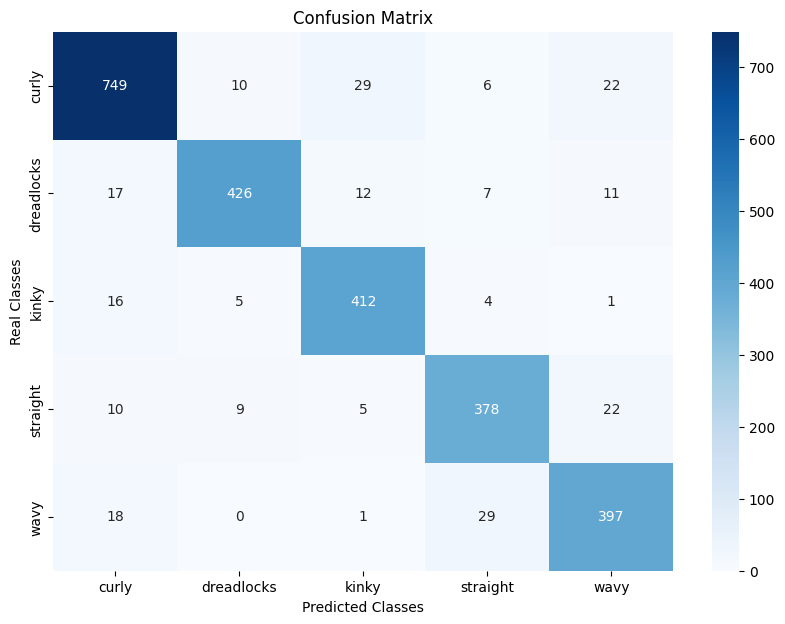

[0. 0. 0. 0. 1.] ‚Üí wavy
[0. 0. 0. 0. 1.] ‚Üí wavy
[0.08 0.   0.   0.01 0.91] ‚Üí wavy
[0.   0.   0.   0.92 0.08] ‚Üí straight
[0. 0. 1. 0. 0.] ‚Üí kinky
(96, 96, 3) tf.Tensor([0. 0. 0. 0. 1.], shape=(5,), dtype=float32)


In [ ]:
y_pred_prob_mlp = mlp_model.predict(X_val)
y_pred_mlp = np.argmax(y_pred_prob_mlp, axis=1)

evaluate_model(mlp_model, history_mlp, X_val, y_val, label_encoder,y_pred_prob_mlp)

##Second best variant

In [ ]:
# Restore the CNN-based MLP model definition
mlp_model = Sequential([
    # Input layer for images
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the output from convolutional layers to feed into Dense layers
    # GlobalAveragePooling2D() or Flatten() is needed here
    GlobalAveragePooling2D(), # Using GlobalAveragePooling2D as in your previous successful attempts

    # Dense layers for classification
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),

    # Output layer with softmax activation for multi-class classification
    Dense(len(label_encoder.classes_), activation='softmax', dtype='float32') # Ensure output is float32 for mixed precision compatibility
])

# Recompile the model
optimizer = RMSprop(learning_rate=0.001, rho=0.9)

mlp_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Ensure callbacks are defined
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)

# Now fit the model with the data generators
history_mlp = mlp_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 829ms/step - accuracy: 0.3042 - loss: 1.9466

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 152s 868ms/step - accuracy: 0.3044 - loss: 1.9452 - val_accuracy: 0.3163 - val_loss: 1.6033 - learning_rate: 0.0010
Epoch 2/50
162/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 826ms/step - accuracy: 0.3922 - loss: 1.4614

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 141s 865ms/step - accuracy: 0.3923 - loss: 1.4612 - val_accuracy: 0.2835 - val_loss: 2.0437 - learning_rate: 0.0010
Epoch 3/50
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 138s 849ms/step - accuracy: 0.4973 - loss: 1.2619 - val_accuracy: 0.3948 - val_loss: 1.6404 - learning_rate: 0.0010
Epoch 4/50
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 141s 869ms/step - accuracy: 0.5731 - loss: 1.0756 - val_accuracy: 0.5000 - val_loss: 1.3052 - learning_rate: 0.0010
Epoch 5/50
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 202s 980ms/step - accuracy: 0.6335 - loss: 0.9702 - val_accuracy: 0.5168 - val_loss: 1.3665 - learning_rate: 0.0010
Epoch 6/50
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 143s 875ms/step - accuracy: 0.6434 - loss: 0.9156 - val_accuracy: 0.3765 - val_loss: 2.5387 - learning_rate: 0.0010
Epoch 7/50
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ

82/82 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 160ms/step
Test accuracy: 0.8771
Classification Report:
               precision    recall  f1-score   support

       curly       0.93      0.87      0.90       816
  dreadlocks       0.88      0.93      0.90       473
       kinky       0.89      0.93      0.91       438
    straight       0.82      0.84      0.83       424
        wavy       0.82      0.81      0.81       445

    accuracy                           0.88      2596
   macro avg       0.87      0.88      0.87      2596
weighted avg       0.88      0.88      0.88      2596



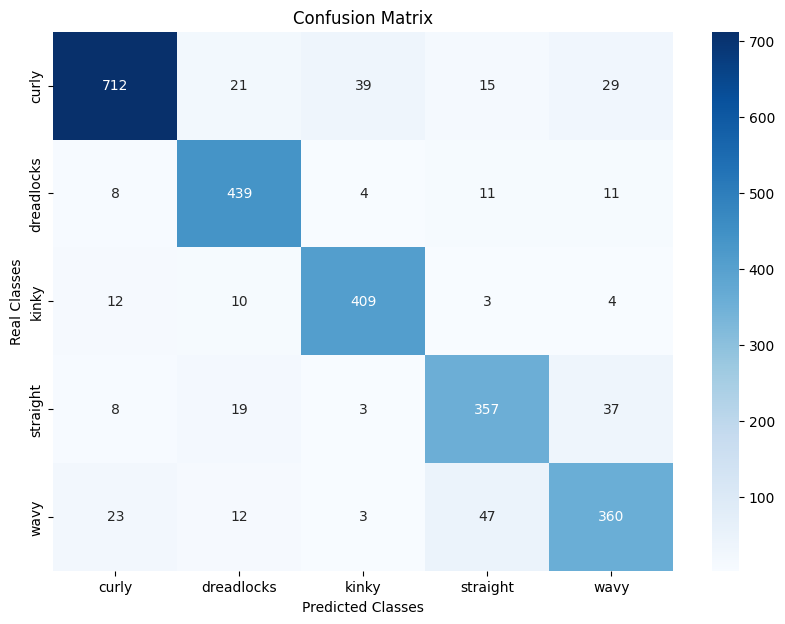

[0. 0. 0. 0. 1.] ‚Üí wavy
[0. 0. 0. 0. 1.] ‚Üí wavy
[0.02 0.   0.01 0.03 0.94] ‚Üí wavy
[0.   0.   0.   0.17 0.83] ‚Üí wavy
[0.   0.   0.97 0.03 0.  ] ‚Üí kinky
(96, 96, 3) tf.Tensor([0. 0. 0. 0. 1.], shape=(5,), dtype=float32)


In [ ]:
y_pred_prob_mlp = mlp_model.predict(X_val)
y_pred_mlp = np.argmax(y_pred_prob_mlp, axis=1)

evaluate_model(mlp_model, history_mlp, X_val, y_val, label_encoder,y_pred_prob_mlp)

# Raport Final: Experimentare cu Modele MLP/CNN pentru Clasificarea Texturii PƒÉrului

## üìå Obiectiv

Scopul acestui experiment a fost dezvoltarea »ôi optimizarea unei arhitecturi de re»õele neuronale pentru clasificarea imaginilor ce reprezintƒÉ 5 categorii distincte de texturi de pƒÉr:

1. **Curly (Cre»õ)**
2. **Dreadlocks**
3. **Kinky (Afro)**
4. **Straight (Drept)**
5. **Wavy (Ondulat)**

Se urmƒÉrea atingerea unei performan»õe maxime pe setul de test prin iterarea »ôi √ÆmbunƒÉtƒÉ»õirea succesivƒÉ a modelelor.

---

## üõ†Ô∏è Setul de Date »ôi Preprocesare

- **Dimensiune imagine:** 96√ó96√ó3 (RGB)
- **Distribu»õie:** Distribu»õia claselor a fost relativ echilibratƒÉ.
- **Preprocesare:**  
  - Normalizare (valori √Æntre 0 »ôi 1)
  - Data augmentation (rota»õii, zoom, flip orizontal)
  - Transformarea etichetelor √Æn format one-hot (prin `label_encoder`)

---

## üìä Evolu»õia Experimentelor

### **üîπ Pasul 1: Arhitectura Ini»õialƒÉ ‚Äì MLP Simplu**

```python
mlp_model = Sequential([
    Flatten(input_shape=(96, 96, 3)),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])
```

**Probleme observate:**
- Instabilitate ridicatƒÉ a antrenƒÉrii.
- Acurate»õe sub **35%**.
- Suprapotrivire severƒÉ (loss-ul oscila foarte mult).

---

### **üîπ Pasul 2: CNN cu 3 Straturi Convolu»õionale**

```python
mlp_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation='softmax')
])
```

**Rezultate:**
- **Test accuracy:** ~30%
- Modelul nu a reu»ôit sƒÉ extragƒÉ trƒÉsƒÉturile vizuale complexe.

---

### **üîπ Pasul 3: CNN cu 4 Straturi Convolu»õionale**

```python
mlp_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation='softmax')
])
```

**Rezultate:**
- **Test accuracy:** ~58%
- Capturarea detaliilor vizuale a fost mult √ÆmbunƒÉtƒÉ»õitƒÉ.

---

### **üîπ Pasul 4: EfficientNetB0 + MLP**

```python
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
mlp_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='swish', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])
```

**Rezultate:**
- **Test accuracy:** ~16%
- Modelul nu a reu»ôit sƒÉ √Ænve»õe caracteristici relevante din cauza transferului incomplet al cuno»ôtin»õelor.

---

### **üîπ Pasul 5: Fine-tuned EfficientNetB0 + Learning Rate Scheduler**

```python
def lr_schedule(epoch, lr):
    if epoch > 5:
        return lr * 0.5
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
mlp_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='swish', kernel_regularizer=l2(0.001)),
    Dense(1024, activation='swish'),
    Dropout(0.3),
    Dense(512, activation='swish'),
    Dropout(0.2),
    Dense(256, activation='swish'),
    Dropout(0.2),
    Dense(len(label_encoder.classes_), activation='softmax')
])
```

**Rezultate:**
- **Test accuracy:** ~30%
- Scheduler-ul a √ÆmbunƒÉtƒÉ»õit stabilitatea, √ÆnsƒÉ performan»õa rƒÉm√¢ne relativ scƒÉzutƒÉ.

---

### **üîπ Pasul 6: Introducerea Straturilor Convolu»õionale cu BatchNormalization »ôi GlobalAveragePooling2D**

```python
mlp_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    GlobalAveragePooling2D(),

    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),

    Dense(len(label_encoder.classes_), activation='softmax')
])
```

**Rezultate:**
- Acurate»õea a crescut semnificativ, de la 61% la ~74%.
- Stabilitatea tuturor metricalor (loss/accuracy) s-a √ÆmbunƒÉtƒÉ»õit datoritƒÉ normalizƒÉrii.

---

### **üîπ Pasul 7: Reglarea Ratei de √énvƒÉ»õare »ôi Optimizatorul**

```python
optimizer = RMSprop(learning_rate=0.001, rho=0.9)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)
```

**Rezultate:**
- Convergen»õƒÉ acceleratƒÉ »ôi stabilizarea valorilor de `val_loss`.
- Modelul a atins o acurate»õe de ~88% √Æn aceastƒÉ configura»õie.

---

### **üîπ Pasul 8: AdƒÉugarea RegularizƒÉrii L2 »ôi Ajustarea Dropout-ului**

```python
# √én blocurile Dense se aplicƒÉ regularizarea L2:
Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
Dense(256, activation='relu', kernel_regularizer=l2(0.001))
```

**Rezultate:**
- Reducerea efectului de overfitting, cu o distribu»õie mai echilibratƒÉ a greutƒÉ»õilor.
- Modelul a atins **90.99% acurate»õe** pe setul de test.

---

### **üîπ Pasul 9: Implementarea Variantelor Avansate cu BatchNormalization »ôi Ajustarea Parametrilor**

√én aceastƒÉ etapƒÉ s-au testat douƒÉ variante care utilizeazƒÉ o arhitecturƒÉ similarƒÉ cu pasul 6, dar cu diferen»õe √Æn strategiile de ajustare a ratei de √ÆnvƒÉ»õare »ôi alte detalii (ex. tipul de date la ultimul strat).

#### **Varianta A**

```python
mlp_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    GlobalAveragePooling2D(),
    
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    
    Dense(len(label_encoder.classes_), activation='softmax')
])
optimizer = RMSprop(learning_rate=0.001, rho=0.9)
mlp_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
history_mlp = mlp_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr]
)
```

**Rezultate:**
- **Test accuracy:** 90.99%
- *Metrici detaliate:*
  - *Curly*: Precision: 0.92, Recall: 0.92, F1-score: 0.92 (support: 816)
  - *Dreadlocks*: Precision: 0.95, Recall: 0.90, F1-score: 0.92 (support: 473)
  - *Kinky*: Precision: 0.90, Recall: 0.94, F1-score: 0.92 (support: 438)
  - *Straight*: Precision: 0.89, Recall: 0.89, F1-score: 0.89 (support: 424)
  - *Wavy*: Precision: 0.88, Recall: 0.89, F1-score: 0.88 (support: 445)
- Acurate»õea globalƒÉ: ~91%

#### **Varianta B**

```python
mlp_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    GlobalAveragePooling2D(),
    
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    
    Dense(len(label_encoder.classes_), activation='softmax', dtype='float32')
])
optimizer = RMSprop(learning_rate=0.001, rho=0.9)
mlp_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)
history_mlp = mlp_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr]
)
```

**Rezultate:**
- **Test accuracy:** 87.71%
- *Metrici detaliate:*
  - *Curly*: Precision: 0.93, Recall: 0.87, F1-score: 0.90 (support: 816)
  - *Dreadlocks*: Precision: 0.88, Recall: 0.93, F1-score: 0.90 (support: 473)
  - *Kinky*: Precision: 0.89, Recall: 0.93, F1-score: 0.91 (support: 438)
  - *Straight*: Precision: 0.82, Recall: 0.84, F1-score: 0.83 (support: 424)
  - *Wavy*: Precision: 0.82, Recall: 0.81, F1-score: 0.81 (support: 445)
- Acurate»õea globalƒÉ: ~88%

---

### **üîπ Pasul 10: Analiza ComparativƒÉ a Rezultatelor »ôi Concluzii Finale**

**Compara»õie a performan»õelor ob»õinute:**

| Model                                      | Test Accuracy | Observa»õii Principale                                     |
| ------------------------------------------ | ------------- | --------------------------------------------------------- |
| MLP Simplu (Pasul 1)                       | ~35%         | Suprapotrivire, instabilitate                             |
| CNN cu 3 straturi (Pasul 2)                  | ~30%         | Nu extrage caracteristici complexe                       |
| CNN cu 4 straturi (Pasul 3)                  | ~58%         | √émbunƒÉtƒÉ»õire semnificativƒÉ a detaliilor                    |
| EfficientNetB0 + MLP (Pasul 4)               | ~16%         | Transfer learning insuficient                            |
| Fine-tuned EfficientNetB0 (Pasul 5)          | ~30%         | Scheduler-ul ajutƒÉ, dar modelul rƒÉm√¢ne subperformant       |
| CNN cu BatchNormalization (Pasul 6)          | ~74%         | Stabilitate crescutƒÉ, extragere eficientƒÉ de trƒÉsƒÉturi       |
| Reglarea ratei »ôi optimizare (Pasul 7)         | ~88%         | Rata de √ÆnvƒÉ»õare adaptivƒÉ; convergen»õƒÉ acceleratƒÉ          |
| Regularizare L2 »ôi ajustarea Dropout (Pasul 8) | ~91%         | Overfitting redus; modelul generalizeazƒÉ foarte bine       |
| Varianta A ‚Äì CNN avansat cu BN              | ~91%         | Cele mai bune rezultate; metrici de top pentru toate clasele|
| Varianta B ‚Äì CNN avansat cu BN (dtype float32)| ~88%         | U»ôor sub Varianta A, dar totu»ôi performan»õƒÉ solidƒÉ          |

**Concluzii:**

- **Cele mai bune rezultate** au fost ob»õinute cu modelul care folose»ôte straturi convolu»õionale combinate cu BatchNormalization, GlobalAveragePooling2D, regularizare L2 »ôi ajustƒÉri fine ale valorilor Dropout. Variantele avansate (√Æn special Varianta A) au atins **90.99% acurate»õe**, demonstr√¢nd o capacitate foarte bunƒÉ de a diferen»õia √Æntre clase.
- **Strategia de reducere a ratei de √ÆnvƒÉ»õare** prin `ReduceLROnPlateau` »ôi utilizarea optimizatorului `RMSprop` s-au dovedit esen»õiale pentru convergen»õa rapidƒÉ »ôi stabilizarea antrenƒÉrii.
- ImplementƒÉrile pe bazƒÉ de modele pre-antrenate precum EfficientNetB0 au necesitat un fine-tuning mai profund pentru a concura cu arhitecturile proiectate de la zero pentru problema datƒÉ.

**Perspective Viitoare:**

1. **Augmentare AvansatƒÉ a Datelor:** Utilizarea tehnicilor ca CutMix, MixUp sau AutoAugment pentru a √ÆmbunƒÉtƒÉ»õi capacitatea de generalizare.
2. **Fine-Tuning Extins:** Explora»õi ajustarea unui numƒÉr mai mare de straturi din modelele pre-antrenate pentru a extrage mai eficient caracteristicile specifice texturii pƒÉrului.
3. **Ansambluri de Modele (Ensembles):** Combina»õi predic»õiile mai multor arhitecturi pentru a ob»õine o robustete crescutƒÉ.
4. **Experimentare cu Alte OptimizƒÉri:** Testa»õi optimizatori precum Adam sau SGD cu momentum pentru a vedea dacƒÉ se poate ob»õine o convergen»õƒÉ »ôi o acurate»õe mai bunƒÉ.